In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from glob import glob
from scipy import signal
from matplotlib.ticker import FormatStrFormatter
from scipy.signal import detrend
from tqdm import tqdm
import obspy
from obspy.signal.trigger import recursive_sta_lta, plot_trigger, trigger_onset
import pickle as pkl

import copy


import pandas as pd
import rasterio
from rasterio.plot import show
from scipy.stats import gaussian_kde

from datetime import timedelta
import datetime
import numpy as np
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter

import pyTMD
import numpy as np
        
import pyTMD.io
import pyTMD.predict
import pyTMD.tools
import pyTMD.utilities
import timescale.time


def sintela_to_datetime(sintela_times):
    '''
    returns an array of datetime.datetime 
    ''' 
    
    days1970 = datetime.datetime.date(datetime.datetime(1970, 1, 1)).toordinal()

    # Vectorize everything
    converttime = np.vectorize(datetime.datetime.fromordinal)
    addday_lambda = lambda x : datetime.timedelta(days=x)
    adddays = np.vectorize(addday_lambda )
    
    day = days1970 + sintela_times/1e6/60/60/24
    thisDateTime = converttime(np.floor(day).astype(int))
    dayFraction = day-np.floor(day)
    thisDateTime = thisDateTime + adddays(dayFraction)

    return thisDateTime

def preprocessing_step(file):

    # Load data #
    f = h5py.File(file)
    attrs = f['Acquisition'].attrs
    data = f['Acquisition']['Raw[0]']['RawData'][:]
    this_time = f['Acquisition']['Raw[0]']['RawDataTime'][:]
    times = sintela_to_datetime(this_time)
    x = np.linspace(0,data.shape[1],data.shape[1]) * attrs['SpatialSamplingInterval']
    

    fs = attrs['PulseRate'] #sample rate

    #filter
    sos = signal.butter(10, 1, 'hp', fs=fs, output='sos')
    filtered = signal.sosfiltfilt(sos, data, axis=0)
    data_normed_filtered = chan_norm(filtered)

    if file[-9:-7] != '00':
        time_start = times[0] - datetime.timedelta(seconds=times[0].second, microseconds=times[0].microsecond)
        forward_step = np.arange(time_start, times[0], 500).shape[0]
        data_locator = np.array([int(i) for i in (this_time-this_time[0])/500]) + forward_step -1
    else:
        data_locator = np.array([int(i) for i in (this_time-this_time[0])/500])



    # this_time = np.arange(0,int(fs*60))* 500 + this_time[0]
    # print(this_time)


    filled_data = np.zeros((int(fs*60),data_normed_filtered.shape[1]))
    filled_times = np.zeros((int(fs*60)), dtype=object)


    filled_times[data_locator] = times
    filled_data[data_locator] = data_normed_filtered
    filt_filled_data = filled_data[:,:]

    return filt_filled_data, filled_times, attrs

def preprocessing_step_single_channel(file, channel=100):

    # Load data #
    f = h5py.File(file)
    attrs = f['Acquisition'].attrs
    data = f['Acquisition']['Raw[0]']['RawData'][:]
    this_time = f['Acquisition']['Raw[0]']['RawDataTime'][:]
    times = sintela_to_datetime(this_time)
    x = np.linspace(0,data.shape[1],data.shape[1]) * attrs['SpatialSamplingInterval']
    data = data[:,channel]

    fs = attrs['PulseRate'] #sample rate

    #filter
    sos = signal.butter(10, 2, 'hp', fs=fs, output='sos')
    filtered = signal.sosfiltfilt(sos, data, axis=0)
    
    data_normed = chan_norm(filtered)

    if file[-9:-7] != '00':
        time_start = times[0] - datetime.timedelta(seconds=times[0].second, microseconds=times[0].microsecond)
        forward_step = np.arange(time_start, times[0], 500).shape[0]
        data_locator = np.array([int(i) for i in (this_time-this_time[0])/500]) + forward_step -1
    else:
        time_start = times[0]
        data_locator = np.array([int(i) for i in (this_time-this_time[0])/500])



    # this_time = np.arange(0,int(fs*60))* 500 + this_time[0]
    # print(this_time)


    filled_data = np.zeros((int(fs*60),))
    filled_times = time_start + (np.arange(0,120000,1) * datetime.timedelta(microseconds=500))


    filled_times[data_locator] = times
    filled_data[data_locator] = filtered
    filt_filled_data = filled_data[:]

    return filt_filled_data, filled_times, attrs

def foo(a, b):
    t = mdates.num2date(a)
    ms = str(t.microsecond)[:1]
    res = f"{t.hour:02}:{t.minute:02}:{t.second:02}.{ms}"
    return res

def chan_norm(das_data):
    data_normed = (das_data - np.mean(das_data, axis=0))/np.std(das_data, axis=0)

    return data_normed

class DataStats:
    def __init__(self, data, attrs, times):
        self.sampling_rate = attrs["PulseRate"]
        self.npts = data.shape[0]
        self.starttime = times[0]
        # self.starttime.isoformat

class DAS:
    def __init__(self, id, data, attrs, times):
        self.id = id
        self.data = data
        self.stats = DataStats(data, attrs, times)


def obspy_stream_from_das(data, attrs,times):
    stats_default = {
        'network':'eastwind',
        'station':'',
        'location':'',
        'channel':'DAS',
        'starttime':times[0].strftime('%Y-%m-%dT%H:%M:%S.%fZ'),
        'endtime':times[-1].strftime('%Y-%m-%dT%H:%M:%S.%fZ'),
        'sampling_rate':attrs['PulseRate'],
        'delta':1/attrs['PulseRate'],
        'npts':0,
        'calib':1.0
    }

    streams = []
    for n,i in enumerate(data.T):
        tr = obspy.Trace(data=i,header=stats_default)
        # tr.stats.station = f'Channel {n}'
        tr.stats.npts = len(i)

        st = obspy.Stream(tr)
        streams.append(st)
    return streams

from obspy.core import AttribDict
from pyproj import Proj
from multiprocessing import Pool

from quakemigrate import QuakeScan, Trigger
from quakemigrate.io import Archive, read_stations
from quakemigrate.lut import compute_traveltimes
from quakemigrate.signal.onsets import STALTAOnset
from quakemigrate.signal.pickers import GaussianPicker

%matplotlib widget


In [2]:
with open('../auto_picked_events_all_5thChannel.pkl', 'rb') as file:
    picks = pkl.load(file)

picks = picks[:int(len(picks)/5)] # We skipped every 5th channel

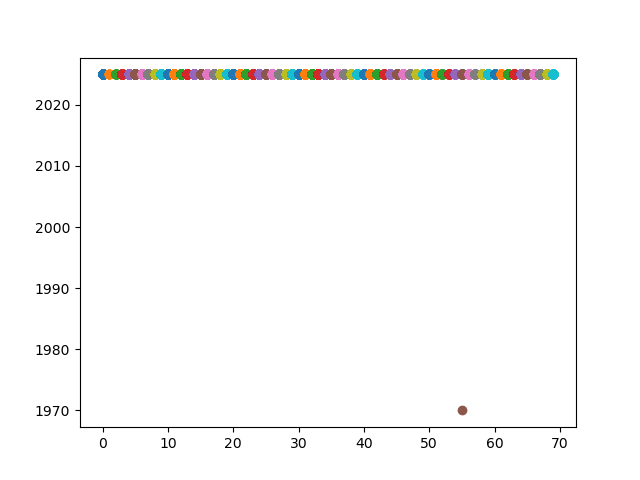

In [3]:
fig,ax = plt.subplots()

for chan,p in enumerate(picks):
    ax.scatter([chan]*len(p),p)


In [4]:


all_trigs_flat_no_duplicates = []

for i in picks:
    all_trigs_flat_no_duplicates.append([i[0]])
for chan in range(len(picks)):
    chan_picks = picks[chan]
    for k in range(1,len(chan_picks), 1):

        try:
            diff = chan_picks[k] - chan_picks[k-1]
            if diff < datetime.timedelta(seconds=0.01):
                # print('duplicate')
                continue

            else:
                all_trigs_flat_no_duplicates[chan].append(chan_picks[k])
        except:
            continue

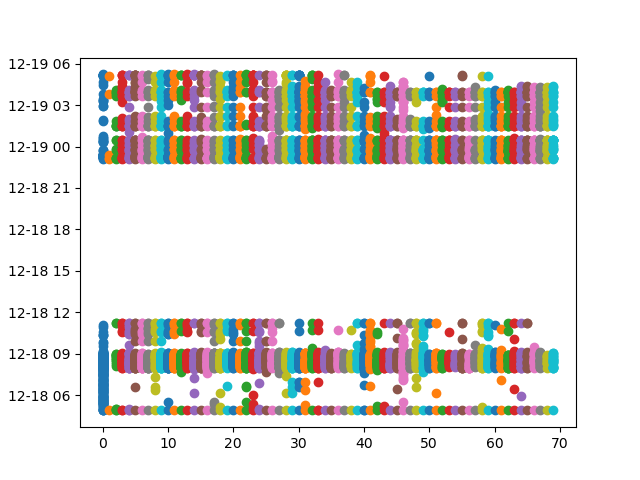

In [5]:
fig,ax = plt.subplots()

for chan,p in enumerate(all_trigs_flat_no_duplicates):
    ax.scatter([chan]*len(p),p)

[{datetime.datetime(2024, 12, 18, 4, 54, 17, 124997),
  datetime.datetime(2024, 12, 18, 4, 54, 41, 799999),
  datetime.datetime(2024, 12, 18, 4, 54, 52, 614998),
  datetime.datetime(2024, 12, 18, 4, 55, 28, 314995),
  datetime.datetime(2024, 12, 18, 4, 59, 6, 935003),
  datetime.datetime(2024, 12, 18, 5, 0, 45, 24996),
  datetime.datetime(2024, 12, 18, 5, 7, 35, 359996),
  datetime.datetime(2024, 12, 18, 5, 10, 42, 559996),
  datetime.datetime(2024, 12, 18, 5, 13, 15, 914998),
  datetime.datetime(2024, 12, 18, 5, 16, 3, 444999),
  datetime.datetime(2024, 12, 18, 5, 20, 3, 115002),
  datetime.datetime(2024, 12, 18, 5, 21, 16, 759996),
  datetime.datetime(2024, 12, 18, 5, 23, 35, 590002),
  datetime.datetime(2024, 12, 18, 5, 25, 9, 650002),
  datetime.datetime(2024, 12, 18, 5, 25, 10, 1),
  datetime.datetime(2024, 12, 18, 5, 26, 43, 765002),
  datetime.datetime(2024, 12, 18, 5, 29, 27, 234996),
  datetime.datetime(2024, 12, 18, 5, 31, 6, 594999),
  datetime.datetime(2024, 12, 18, 5, 33, 